# Overengineering 101
### We're talking about training (More Thomas than ML)

Evan Miller, Tax Ventures, AI + Data team

Our team takes pride in having AI and Data professionals work closely on solving the client problem data and AI specialists work together. 

So it's my time to jump from the AI side to the data side with a deep dive into data labelling. 

**This is my story (hint: it's way harder than I imagined).**

## Why???

- Got given a Raspberry Pi by my sis a few years ago.
- Idea #1 find the optimal time for going for a walk such that I'd see as many dogs as possible
- Idea #2 count how many sirens go past my flat
    + Live between Charing Cross and Hammersmith Hospitals, so this number is LARGE
- Idea #3 count how many trains go past my flat (less grim)

https://github.com/evanmiller29/rasp_pi_siren_train_counter

## Confessions

**Before this I'd never gathered my own dataset**

After this I feel like every data scientist should do this. It gives you a lot of humility towards crap data sources.

So be nice, even if there isn't as much "data" or "science" in here as we'd all like :D

## System Architecture

<img src="system_diagram.PNG" width="500">

## What does my code do

1. Creates Azure Blob container
2. Gets inputs from the user
    - How long should each file be, how many files do you want to record
    - Technical audio analysis things
2. Finds USB mic
3. Records
4. Saves properties
5. Zips recordings
6. Uploads recordings to Azure

## How many recordings did I do?

A few, then I lost a few. But here's what my Azure Blob Storage looks like:
So there were a few 

<img src="blob_storage_image.PNG" width="500">



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display

import librosa
import librosa.display
import IPython

In [2]:
data_dir = "data"

files = os.listdir(data_dir)
json_settings_file = [file for file in files if '.json' in file][0]
audio_files = [file for file in files if '.json' not in file]

with open(os.path.join(data_dir, json_settings_file)) as f:
    json_settings = json.load(f)
    
pd.DataFrame([json_settings]).T

,0
form,8
channel,1
sample_rate,44100
chunk_size,4096
record_secs,60
usb_audio_device_num,2
output_dir,/home/pi/Desktop/wav_files/raw_files/202004061233
location,bedroom


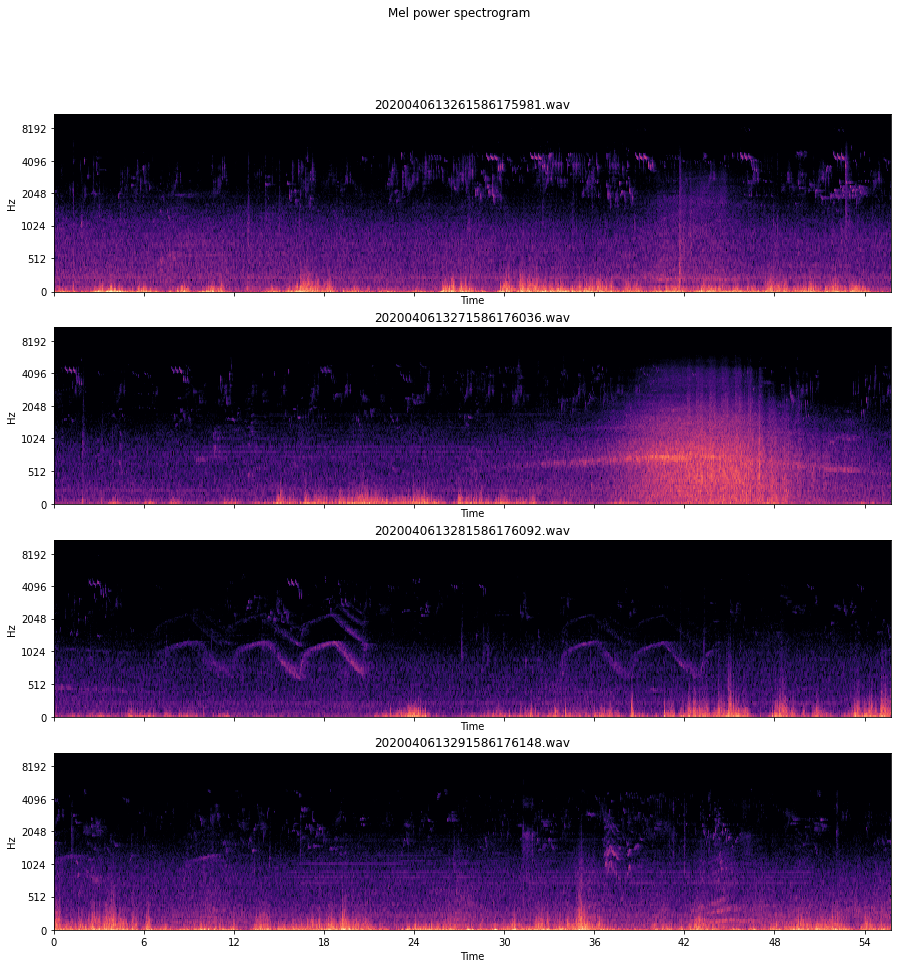

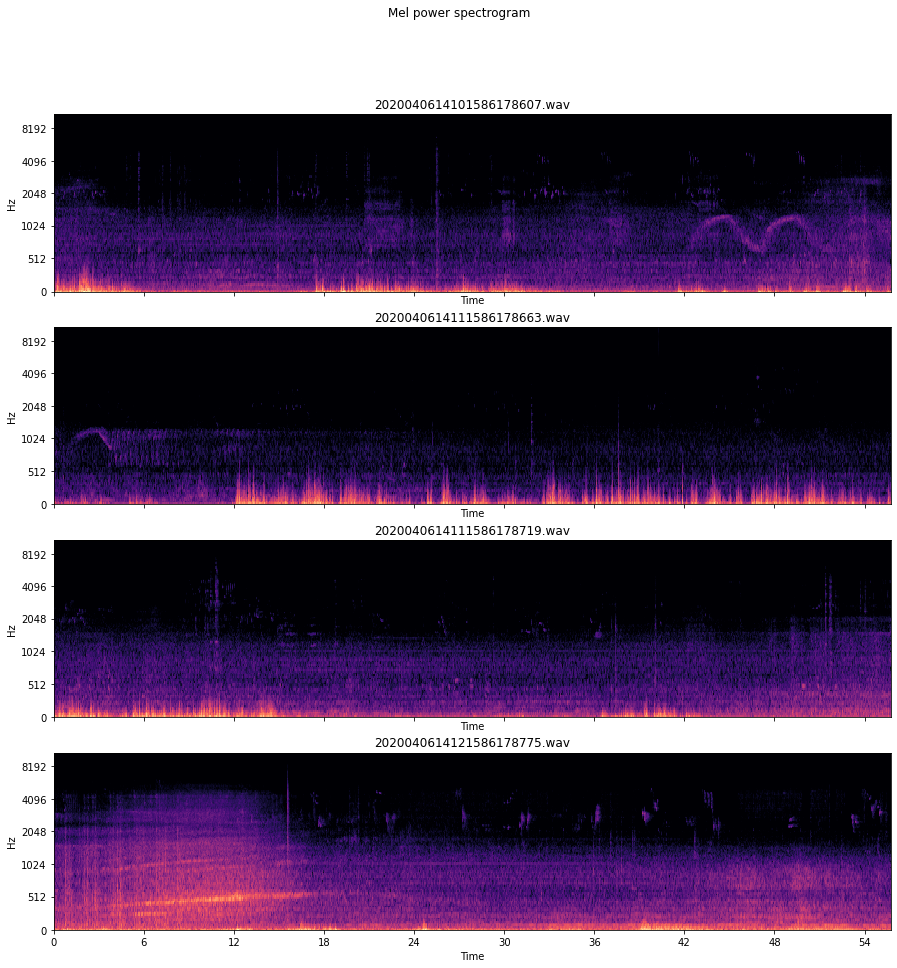

In [3]:
audio_files_subset = audio_files[0:4]
fig, axs = plt.subplots(nrows=len(audio_files_subset), figsize=(15, 15), sharey=True, sharex=True)
axes = axs.reshape(-1)

for i, audio_file in enumerate(audio_files_subset):
    
    y, sr = librosa.load(os.path.join(data_dir, audio_file), sr=None)
    S = librosa.feature.melspectrogram(y, sr=json_settings['sample_rate'], n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=json_settings['sample_rate'], x_axis='time', y_axis='mel', ax=axes[i])
    axes[i].set(title=audio_file)

fig.suptitle('Mel power spectrogram');
fig.savefig('spectogram_0_5.png')

audio_files_subset = audio_files[6:10]
fig, axs = plt.subplots(nrows=len(audio_files_subset), figsize=(15, 15), sharey=True, sharex=True)
axes = axs.reshape(-1)

for i, audio_file in enumerate(audio_files_subset):
    
    y, sr = librosa.load(os.path.join(data_dir, audio_file), sr=None)
    S = librosa.feature.melspectrogram(y, sr=json_settings['sample_rate'], n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=json_settings['sample_rate'], x_axis='time', y_axis='mel', ax=axes[i])
    axes[i].set(title=audio_file)

fig.suptitle('Mel power spectrogram');
fig.savefig('spectogram_6_10.png')

## Finding Thomas pt.1 - can we use image classification?

### #2 NOT a train

<img src="spectogram_0_5.png" width="500">

## Finding Thomas pt.2 - can we use image classification?

### #4 IS a train

<img src="spectogram_6_10.png" width="500">

## Going from raw to labelled (Label Studio)

Label studio is an Open Source data labelling (go figure) solution.
It supports labelling the following data types and is easily extensible:

- Audio
- Image
- Text
- HTML

It doesn't have great Docker support (like Doccano) but they're working on that.

But anyway, here's what it looks like:

```label-studio start train_sample```

In [4]:
data_path = "train_detection\completions"
labelled_data = os.listdir(data_path)

results = []
for file in labelled_data:

    try:
        with open(os.path.join(data_path, file)) as f:
    
            data = json.loads(f.read())
            label = data['completions'][0]['result'][0]['value']['choices'][0]
            file_name = data['task_path'].split('\\')[-1]

            d = {
                'task_json': file,
                'label': label,
                'file_name': file_name
            }

            results.append(d)
            
    except:
        
        print("File didn't work for some reason")

File didn't work for some reason
File didn't work for some reason


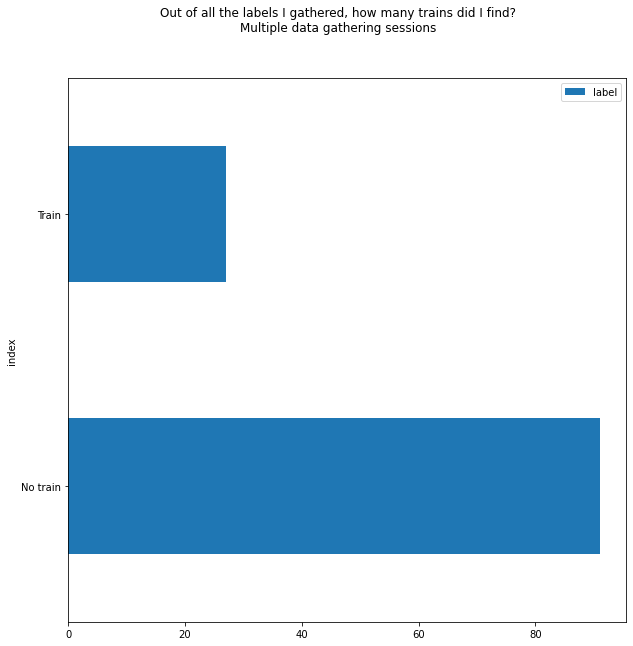

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

results_df = pd.DataFrame(results)
graph_df = results_df['label'].value_counts().reset_index()

graph_df = graph_df.set_index('index')
graph_df.plot(kind='barh', ax=ax)

fig.suptitle('Out of all the labels I gathered, how many trains did I find?\nMultiple data gathering sessions');
fig.savefig('trains_no_trains.png');

## So how many did I trains did I find??

<img src="trains_no_trains.png" width="500">

## Why did I stop this project a bit early?

- I realized that the current approach had it's limitations
    + Creating a training set with one row for each file would be very difficult
    + Audio segmentation would be better
        + That would require me listening to most of those files again, and I don't have the patience for that
- There is a huge investment in making sure that data gathering is as perfect as it can be right off the bat
    + But it's so important to nail
    + This project ran to a standstill as I realized that data gathering was breaking, causing large amounts of re-work
- Raspberry Pis are real fun, and I wanted to keep playing around with it instead of needing it to record audio

## The plus side - things I learnt

- It made me think a lot about data reliability and quality. 
    + I was really good before at saying "this dataset is crap"
    + But the tougher question is: "How can you make this dataset good?"
    + Create your own data quality metrics: predicted number of files vs actual
- I realized gathering my own data is approachable
    + Now I'm using Arduino to gather information on my indoor garden with a view to see what conditions grow plants more effectively
- Taking stretch projects like this in small bite sized pieces make things so much easier
    + First understanding Raspberry pi, then audio analysis, then Azure and then data labelling made this project doable